## 3. Model Selection

### 3.1. Importing Libraries

In [2]:
import pandas as pd
# Data Preprocessing
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    RobustScaler, 
    MinMaxScaler, 
    StandardScaler
)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

# Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_validate, 
    cross_val_score, 
    GridSearchCV
)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error
)

# Regression Models
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, 
    Ridge, 
    ElasticNet
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Ensemble Models
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    StackingRegressor, 
    ExtraTreesRegressor, 
    AdaBoostRegressor
)

# Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# Visualization & Utilities
import shap
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


### 3.2. Data Loading

In [3]:
# Load the dataset
dataset_path = 'daegu_cleaned.csv'
df = pd.read_csv(dataset_path)

# Feature Engineering: Adding price per square meter
df['price_per_sqm'] = df['SalePrice'] / df['Size(sqf)']

# Define feature columns
numerical_cols = [
    'N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
    'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
    'N_FacilitiesInApt', 'Size(sqf)', 'price_per_sqm'
]

categorical_cols = ['SubwayStation', 'HallwayType']
    

### 3.3. Feature, Train-test Split, Transforming, Preprocessing

In [4]:

# Define Features and Target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split the data before preprocessing to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Preprocessor (Column Transformation)
preprocessor = ColumnTransformer(
    transformers=[
        ('ordencoder', OrdinalEncoder(), ['TimeToSubway']),
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Apply preprocessing to the entire dataset (fit only on training data)
preprocessor.fit(X_train)  # Fit only on the training data

# Transform both training and test data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### 3.4. Model Training and Hyperparameter Tuning

In [5]:
# Define models and parameter grids
models = {
    'Lasso': Lasso(max_iter=10000),  # Increase max_iter
    'Ridge': Ridge(max_iter=10000),  # Increase max_iter
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

params = {
    'Lasso': {'alpha': [0.001, 0.01, 0.1]},  # Consider adjusting alpha
    'Ridge': {'alpha': [0.001, 0.01, 0.1]},  # Consider adjusting alpha
    'Random Forest': {'n_estimators': [100, 200]},
    'Gradient Boosting': {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [10, 20, 30], 'min_samples_split': [2, 10, 20]},
    'XGBoost': {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5], 'subsample': [0.8, 1.0]
    }
}

# Hyperparameter tuning
results = {}
for name, model in models.items():
    grid = GridSearchCV(model, params[name], cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid.fit(X_train_transformed, y_train)  # Fit the model on the transformed training data
    results[name] = {
        'model': grid.best_estimator_,
        'score': grid.best_score_,
        'params': grid.best_params_
    }
    print(f"{name} Best Score: {grid.best_score_}")
    print(f"{name} Best Parameters: {grid.best_params_}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.529e+10, tolerance: 1.805e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.636e+10, tolerance: 1.725e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

Lasso Best Score: -667107977.5044152
Lasso Best Parameters: {'alpha': 0.1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Ridge Best Score: -667064304.5943222
Ridge Best Parameters: {'alpha': 0.1}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Random Forest Best Score: -37531655.448597655
Random Forest Best Parameters: {'n_estimators': 200}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Gradient Boosting Best Score: -41682434.704619214
Gradient Boosting Best Parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVR Best Score: -5771853319.4622755
SVR Best Parameters: {'C': 10, 'kernel': 'linear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Decision Tree Best Score: -60188594.76315789
Decision Tree Best Parameters: {'max_depth': 30, 'min_samples_split': 2}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
XGBoost Best Score: -30151478.23345207
XGBoost Best Para

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Ensure that the preprocessing is done correctly
# Create a preprocessing pipeline with the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ordencoder', OrdinalEncoder(), ['TimeToSubway']),
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Evaluate models
evaluation_results = {}
for name, info in results.items():
    model = info['model']
    
    # Apply preprocessing to both train and test data
    X_train_transformed = preprocessor.fit_transform(X_train)  # Fit and transform on train
    X_test_transformed = preprocessor.transform(X_test)  # Transform test data
    
    # Fit the model on the training data
    model.fit(X_train_transformed, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test_transformed)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Save evaluation results
    evaluation_results[name] = {
        'model': model, 'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MSE': mse, 'MAPE': mape
    }
    print(f"\n{name} Model Evaluation:")
    print(f"RMSE: {rmse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2%}")



Lasso Model Evaluation:
RMSE: 26723.87, R²: 0.9319, MAE: 18438.18, MSE: 714165015.47, MAPE: 11.13%

Ridge Model Evaluation:
RMSE: 26722.52, R²: 0.9319, MAE: 18436.09, MSE: 714093155.14, MAPE: 11.13%

Random Forest Model Evaluation:
RMSE: 5547.51, R²: 0.9971, MAE: 2559.21, MSE: 30774825.67, MAPE: 1.15%

Gradient Boosting Model Evaluation:
RMSE: 5678.34, R²: 0.9969, MAE: 3835.11, MSE: 32243498.21, MAPE: 2.02%

SVR Model Evaluation:
RMSE: 70917.54, R²: 0.5205, MAE: 54914.95, MSE: 5029297040.33, MAPE: 31.77%

Decision Tree Model Evaluation:
RMSE: 7627.26, R²: 0.9945, MAE: 3430.06, MSE: 58175160.25, MAPE: 1.54%

XGBoost Model Evaluation:
RMSE: 4134.88, R²: 0.9984, MAE: 2648.91, MSE: 17097264.92, MAPE: 1.32%


### 3.6. Ranking models

In [7]:
# Convert evaluation results into DataFrame
import pandas as pd

evaluation_df = pd.DataFrame([
    {'model_name': name, **metrics} for name, metrics in evaluation_results.items()
]).sort_values(by='RMSE', ascending=True)

# Display Results
print("\n### Model Comparison Results ###")
print(evaluation_df)

# Highlight the Best Model
best_model = evaluation_df.loc[evaluation_df['RMSE'].idxmin()]

print(f"\nThe best model is: {best_model['model_name']} with RMSE: {best_model['RMSE']:.2f}, R²: {best_model['R2']:.4f}, MAE: {best_model['MAE']:.2f}")



### Model Comparison Results ###
          model_name                                              model  \
6            XGBoost  XGBRegressor(base_score=None, booster=None, ca...   
2      Random Forest  (DecisionTreeRegressor(max_features=1.0, rando...   
3  Gradient Boosting  ([DecisionTreeRegressor(criterion='friedman_ms...   
5      Decision Tree                DecisionTreeRegressor(max_depth=30)   
1              Ridge                   Ridge(alpha=0.1, max_iter=10000)   
0              Lasso                   Lasso(alpha=0.1, max_iter=10000)   
4                SVR                         SVR(C=10, kernel='linear')   

           RMSE        R2           MAE           MSE      MAPE  
6   4134.883907  0.998370   2648.905301  1.709726e+07  0.013186  
2   5547.506257  0.997066   2559.209417  3.077483e+07  0.011499  
3   5678.335867  0.996926   3835.109664  3.224350e+07  0.020232  
5   7627.264270  0.994454   3430.061185  5.817516e+07  0.015450  
1  26722.521497  0.931923  18436.09

### 3.6. Residual Analysis

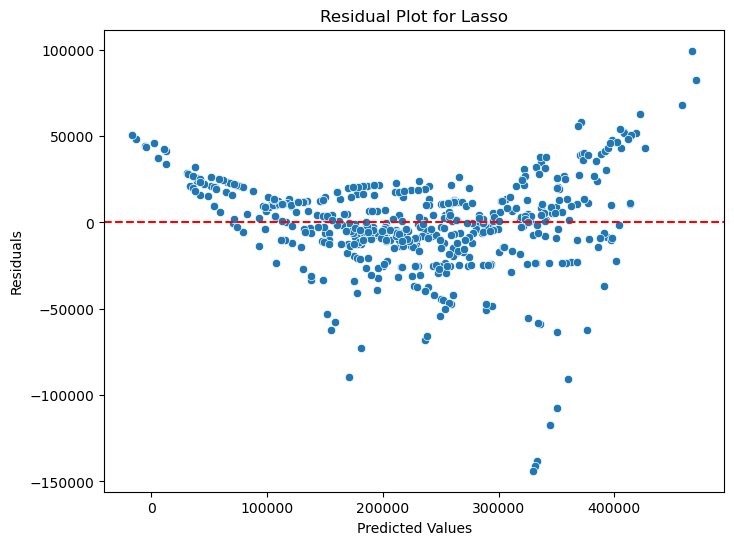

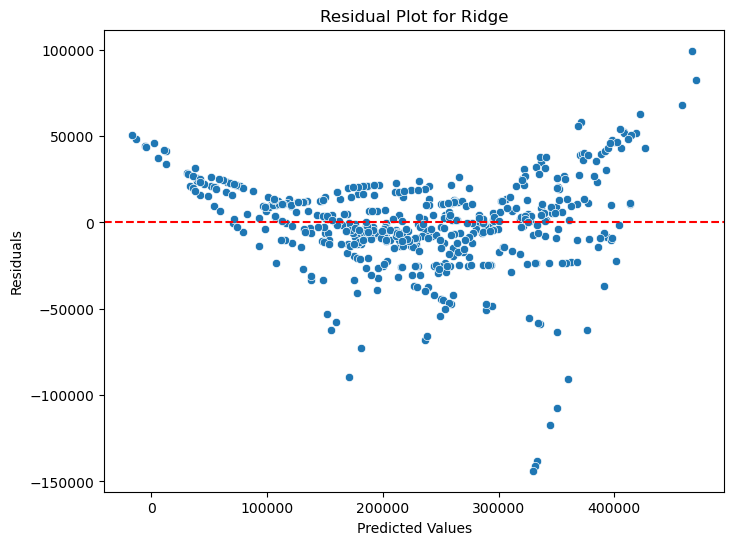

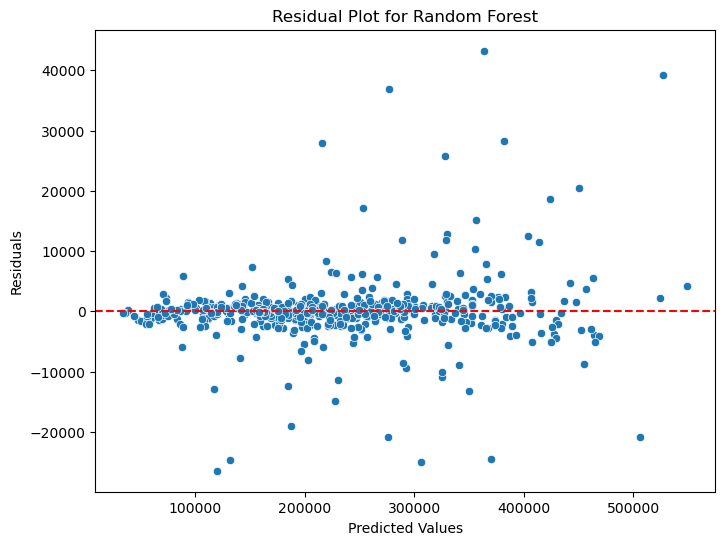

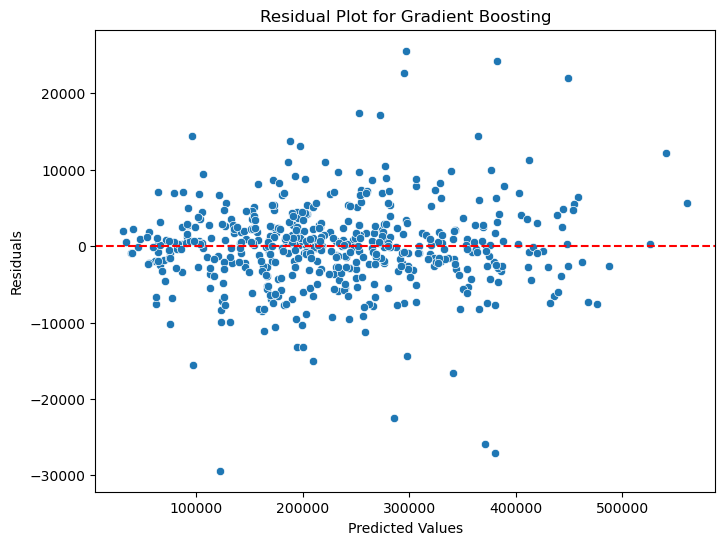

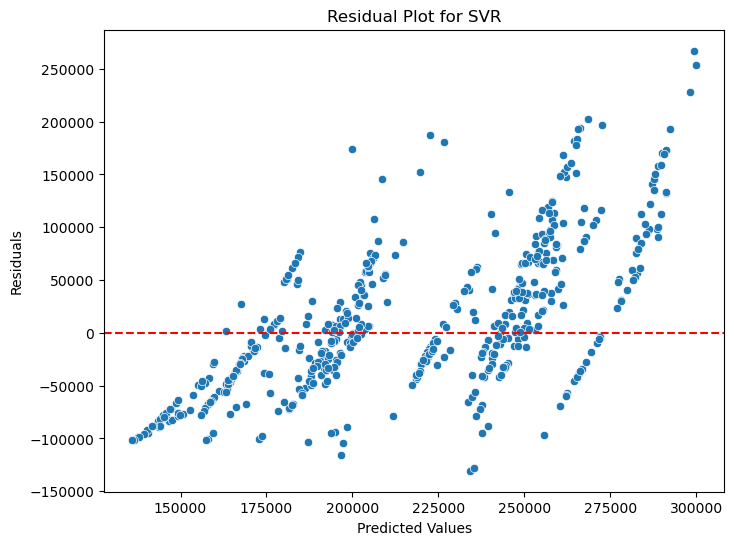

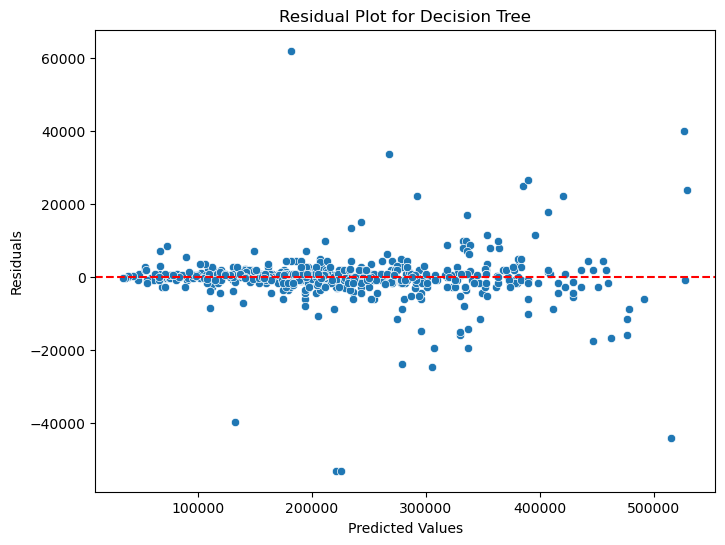

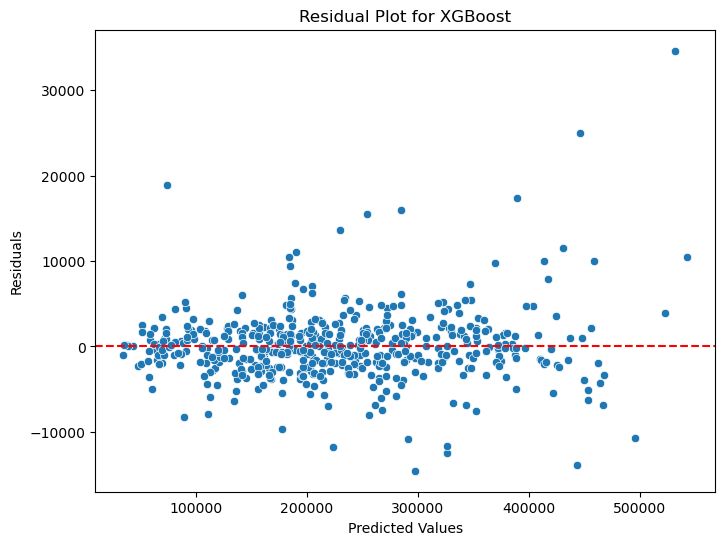

In [7]:
# Residual Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Perform Residual Analysis
for name, metrics in evaluation_results.items():
    model = metrics['model']

    # Apply the preprocessor to the test data before prediction
    X_test_transformed = preprocessor.transform(X_test)  # Transform the test data
    y_pred = model.predict(X_test_transformed)
    residuals = y_test - y_pred

    # Residual Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {name}')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()


#### Rank Models based on residual analysis


Rank 1: XGBoost
  Mean Residual: 66.19
  Std Residual: 4134.35
  Durbin-Watson Stat: 1.92
  Breusch-Pagan p-value: 0.0002
  Outliers Count: 10


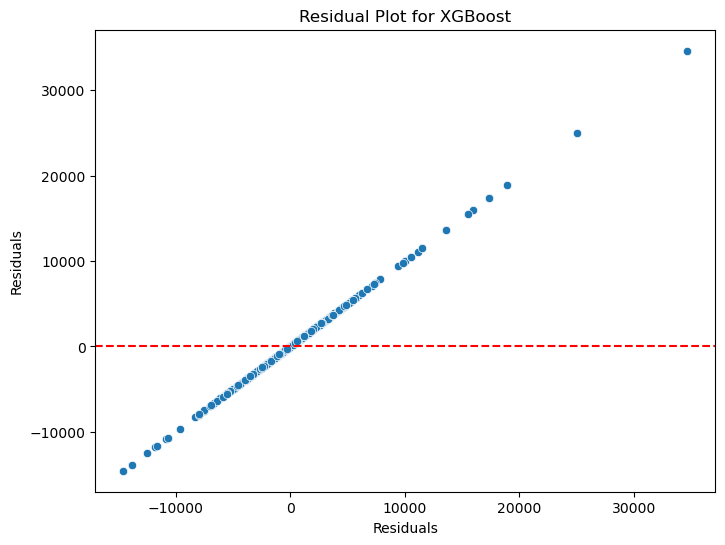


Rank 2: Gradient Boosting
  Mean Residual: -77.63
  Std Residual: 5662.07
  Durbin-Watson Stat: 2.02
  Breusch-Pagan p-value: 0.0006
  Outliers Count: 10


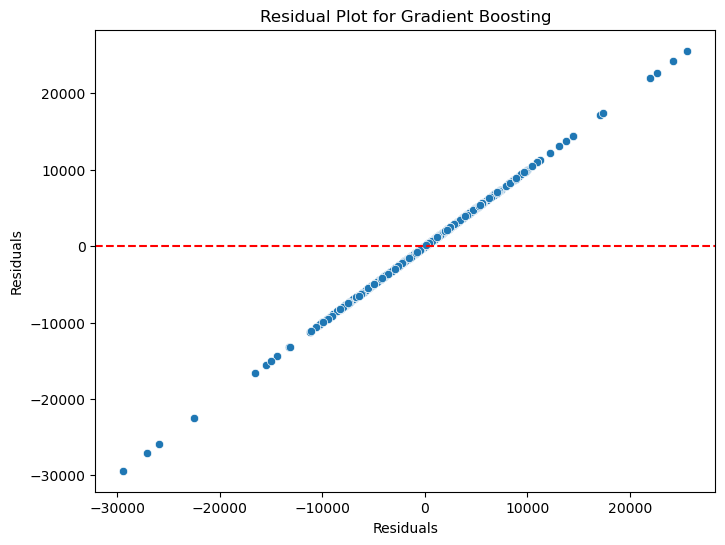


Rank 3: Random Forest
  Mean Residual: 85.65
  Std Residual: 5628.98
  Durbin-Watson Stat: 1.92
  Breusch-Pagan p-value: 0.0000
  Outliers Count: 16


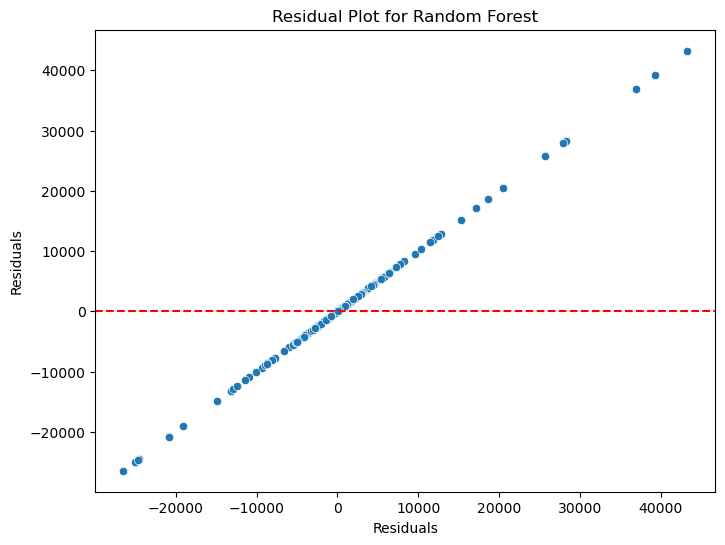


Rank 4: Decision Tree
  Mean Residual: -224.34
  Std Residual: 7298.24
  Durbin-Watson Stat: 1.92
  Breusch-Pagan p-value: 0.0000
  Outliers Count: 14


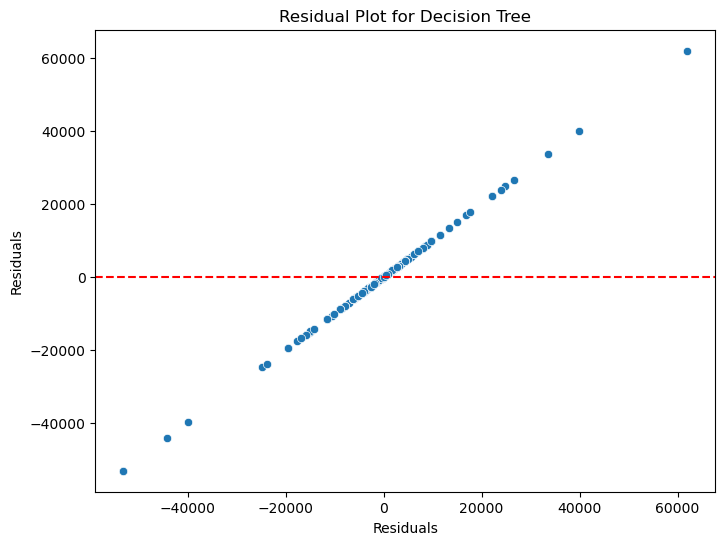


Rank 5: Ridge
  Mean Residual: -566.39
  Std Residual: 26716.52
  Durbin-Watson Stat: 2.07
  Breusch-Pagan p-value: 0.0000
  Outliers Count: 9


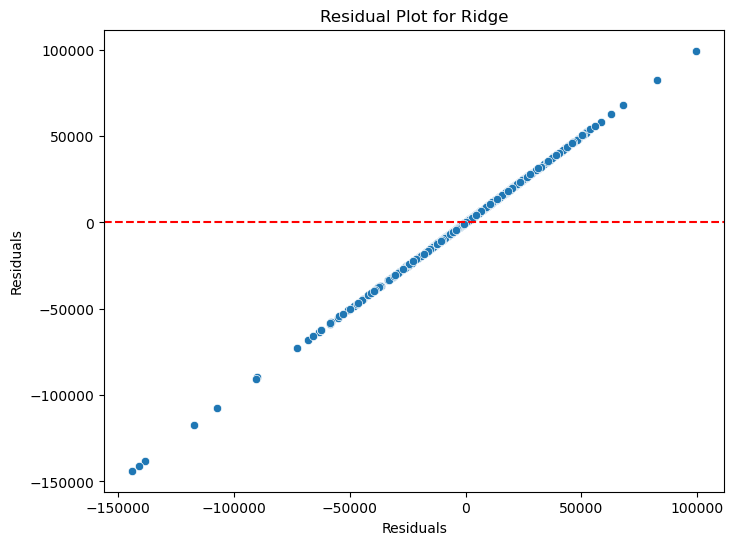


Rank 6: Lasso
  Mean Residual: -566.98
  Std Residual: 26717.85
  Durbin-Watson Stat: 2.07
  Breusch-Pagan p-value: 0.0000
  Outliers Count: 9


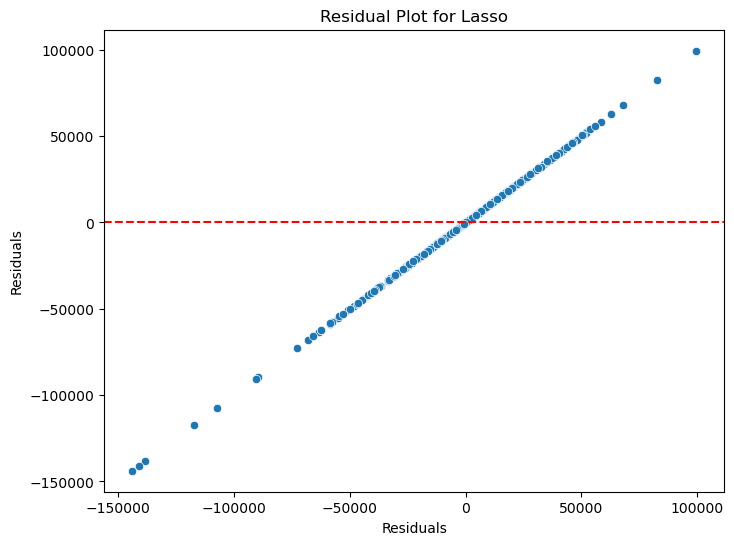


Rank 7: SVR
  Mean Residual: 12024.79
  Std Residual: 69890.64
  Durbin-Watson Stat: 1.86
  Breusch-Pagan p-value: 0.0000
  Outliers Count: 3


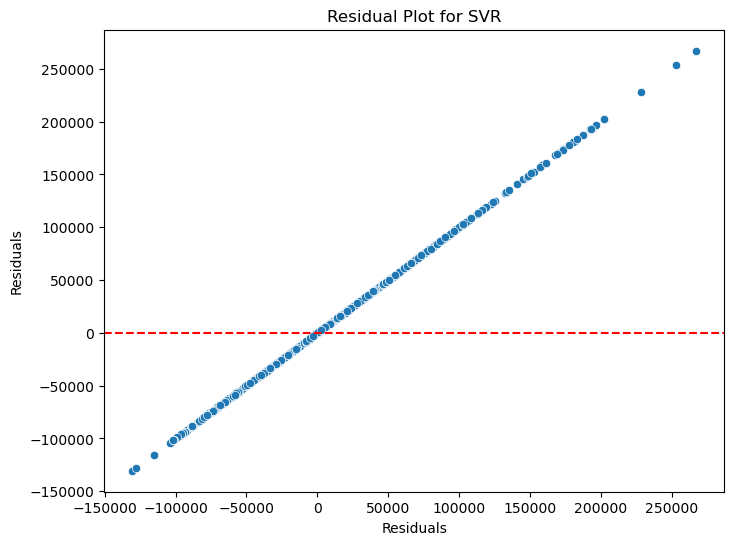

In [10]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate residual metrics for each model
def residual_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    # Mean and Standard Deviation of Residuals
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    
    # Durbin-Watson test for autocorrelation
    dw_stat = durbin_watson(residuals)
    
    # Add constant to X_test for Breusch-Pagan test
    X_test_with_const = sm.add_constant(X_test)
    
    # Breusch-Pagan test for heteroscedasticity
    _, pval_bp, _, _ = het_breuschpagan(residuals, X_test_with_const)
    
    # Count outliers (Residuals beyond 3 standard deviations)
    outliers = np.sum(np.abs(residuals) > 3 * std_residual)
    
    return {
        'mean_residual': mean_residual,
        'std_residual': std_residual,
        'dw_stat': dw_stat,
        'bp_p_value': pval_bp,
        'outliers': outliers,
        'residuals': residuals
    }

# Analyze residuals for each model and store results
residual_analysis_results = {}

for name, metrics in evaluation_results.items():
    model = metrics['model']
    
    # Apply preprocessor to test data
    X_test_transformed = preprocessor.transform(X_test)
    
    # Calculate residual metrics for each model
    metrics = residual_metrics(model, X_test_transformed, y_test)
    residual_analysis_results[name] = metrics

# Rank models based on residual analysis
# For ranking, you can define your ranking criteria based on metrics like:
# 1. Minimize mean residual (close to 0)
# 2. Minimize standard deviation of residuals (consistent residuals)
# 3. Durbin-Watson stat close to 2 (no autocorrelation)
# 4. High p-value for Breusch-Pagan test (indicating no heteroscedasticity)
# 5. Minimize outliers

ranked_models = sorted(residual_analysis_results.items(), key=lambda item: (
    abs(item[1]['mean_residual']),  # Minimize mean residual
    item[1]['std_residual'],        # Minimize standard deviation
    abs(item[1]['dw_stat'] - 2),    # Maximize Durbin-Watson stat (close to 2)
    item[1]['bp_p_value'],          # Maximize p-value for Breusch-Pagan (no heteroscedasticity)
    item[1]['outliers']             # Minimize outliers
))

# Display the ranked models
for rank, (model_name, metrics) in enumerate(ranked_models, 1):
    print(f"\nRank {rank}: {model_name}")
    print(f"  Mean Residual: {metrics['mean_residual']:.2f}")
    print(f"  Std Residual: {metrics['std_residual']:.2f}")
    print(f"  Durbin-Watson Stat: {metrics['dw_stat']:.2f}")
    print(f"  Breusch-Pagan p-value: {metrics['bp_p_value']:.4f}")
    print(f"  Outliers Count: {metrics['outliers']}")

    # Optionally, plot residuals for each model
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=metrics['residuals'], y=metrics['residuals'])
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel("Residuals")
    plt.ylabel("Residuals")
    plt.show()


**prediction accuracy** is prioritized, so we decided to use XGBoost

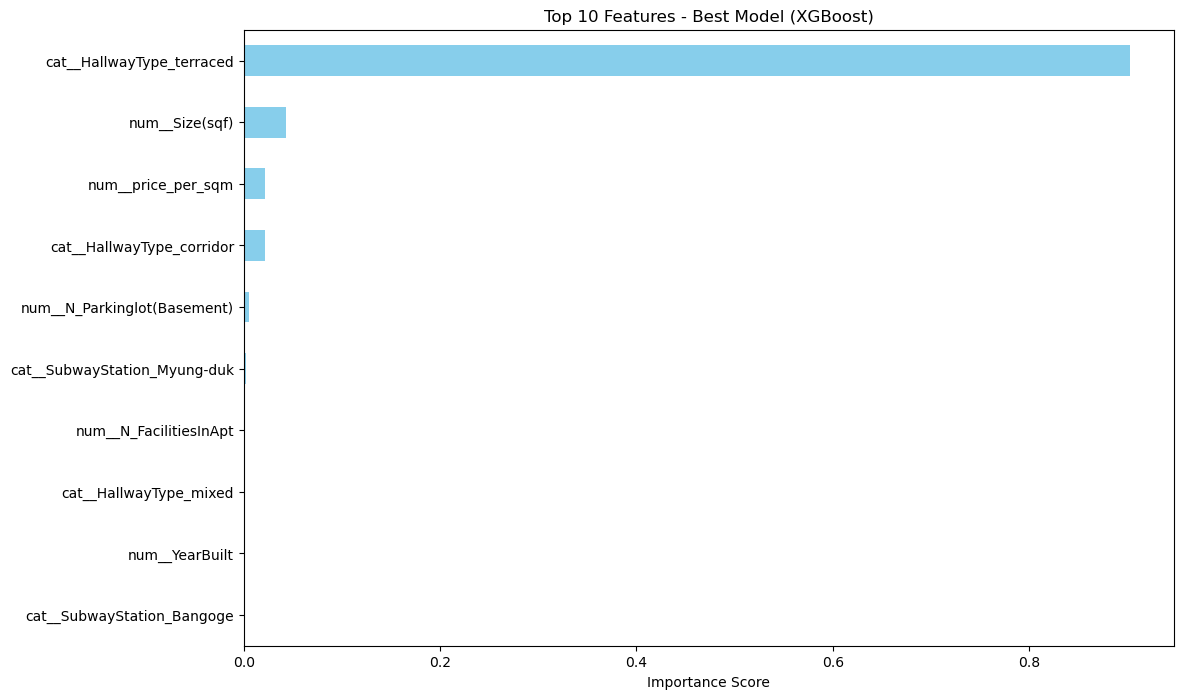

In [13]:
# Extract the best model
best_model = evaluation_results['XGBoost']['model']

# Get feature importances
xgb_importances = pd.Series(best_model.feature_importances_, index=feature_names)

# Sort and plot
plt.figure(figsize=(12, 8))
xgb_importances.nlargest(10).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 10 Features - Best Model (XGBoost)")
plt.xlabel("Importance Score")
plt.show()


In [15]:
# Import necessary libraries
import pandas as pd

# Get transformed data
X_train_transformed_df = pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out()
)

# Display the first few rows
X_train_transformed_df.head()


,ordencoder__TimeToSubway,num__N_FacilitiesNearBy(ETC),num__N_FacilitiesNearBy(PublicOffice),num__N_SchoolNearBy(University),num__N_Parkinglot(Basement),num__YearBuilt,num__N_FacilitiesInApt,num__Size(sqf),num__price_per_sqm,cat__SubwayStation_Bangoge,cat__SubwayStation_Banwoldang,cat__SubwayStation_Chil-sung-market,cat__SubwayStation_Daegu,cat__SubwayStation_Kyungbuk_uni_hospital,cat__SubwayStation_Myung-duk,cat__SubwayStation_Sin-nam,cat__SubwayStation_no_subway_nearby,cat__HallwayType_corridor,cat__HallwayType_mixed,cat__HallwayType_terraced
0,0.0,-0.888192,-0.050444,-1.145317,0.217214,0.557139,-0.292807,1.799560,0.520352,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,-0.888192,0.487449,0.193074,1.011917,1.221005,0.577701,-0.915765,2.237706,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-0.888192,-0.050444,-1.145317,0.217214,0.557139,-0.292807,1.799560,0.369385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,-0.888192,-1.664122,-0.476121,0.048492,0.446495,-0.292807,-0.464076,0.369226,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,-0.888192,-0.588336,-0.476121,-1.262158,-2.651547,-1.163316,-0.243423,-1.315531,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


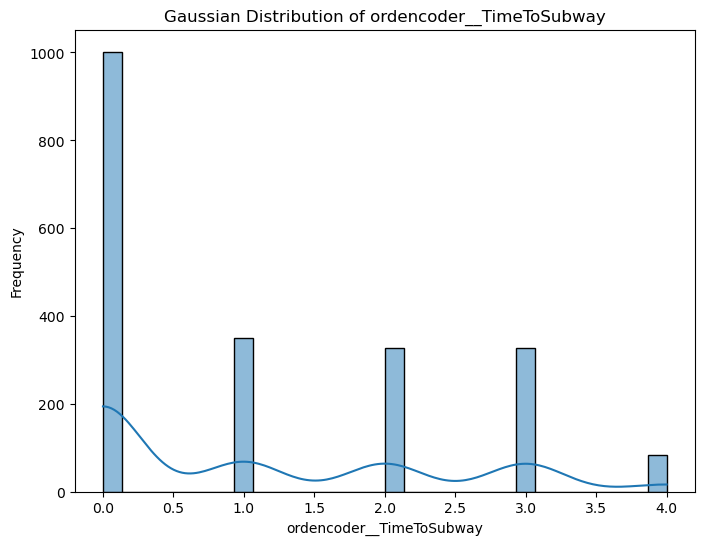

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


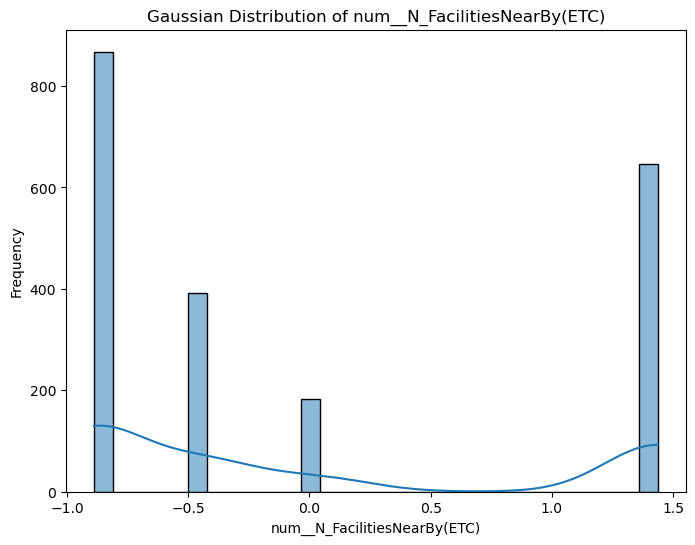

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


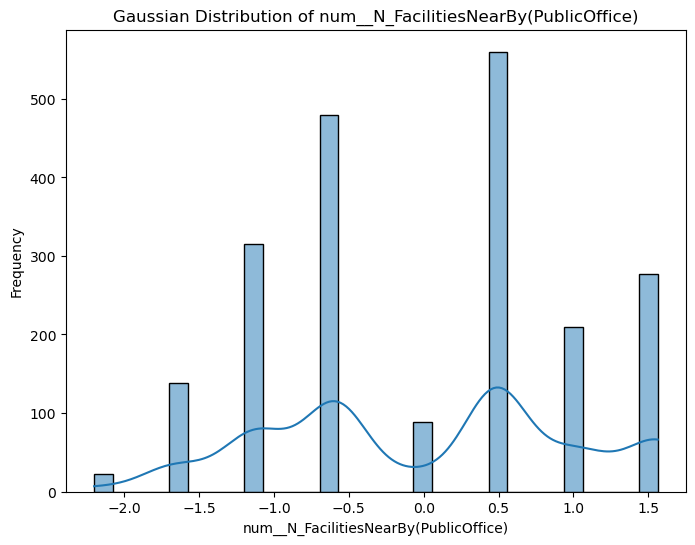

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


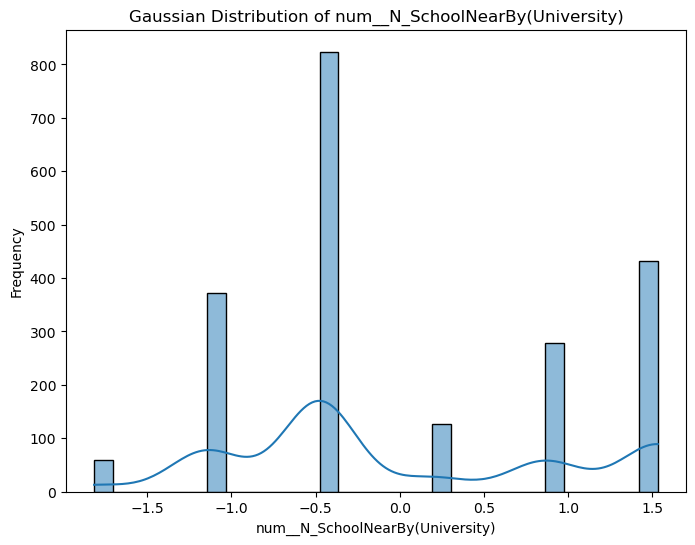

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


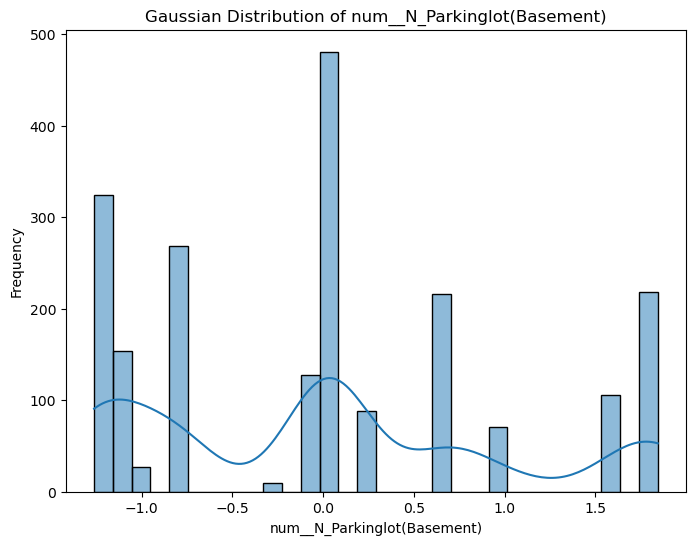

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


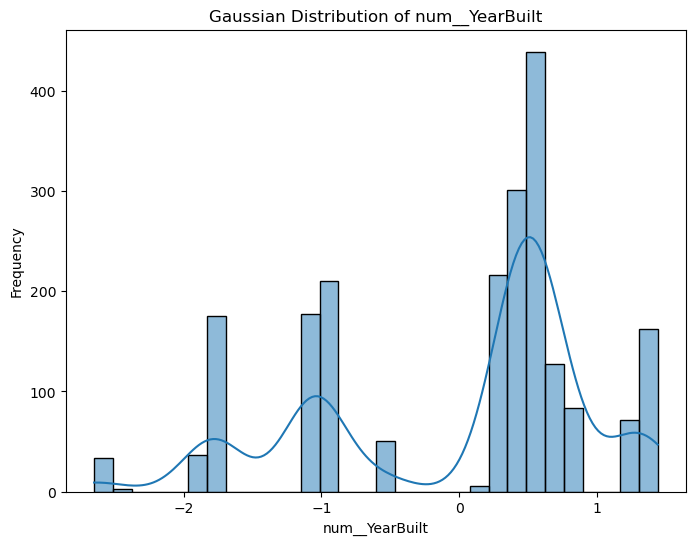

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


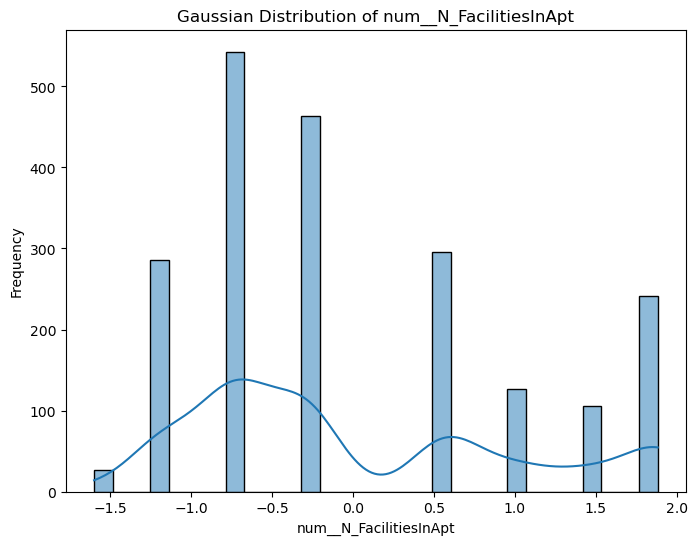

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


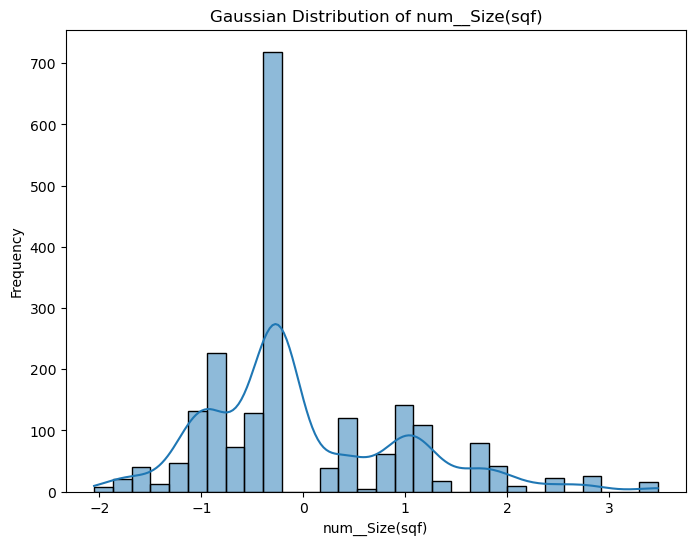

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


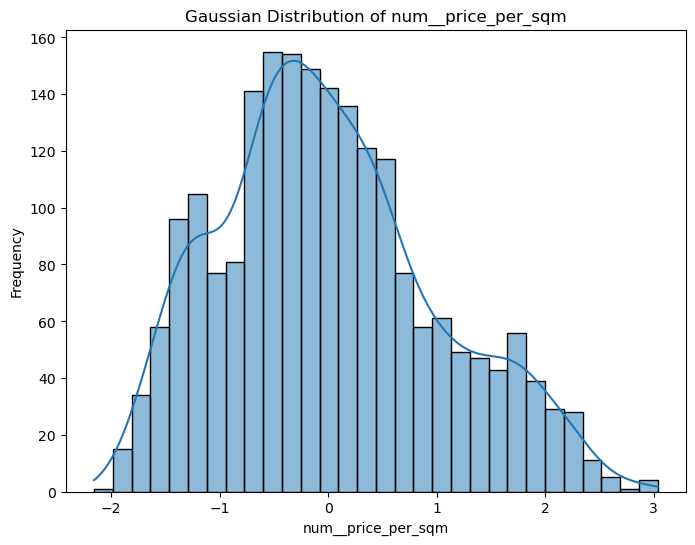

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


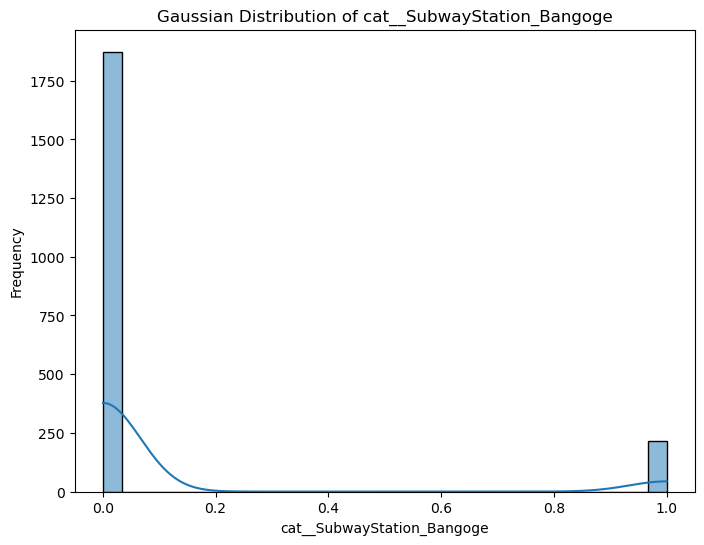

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


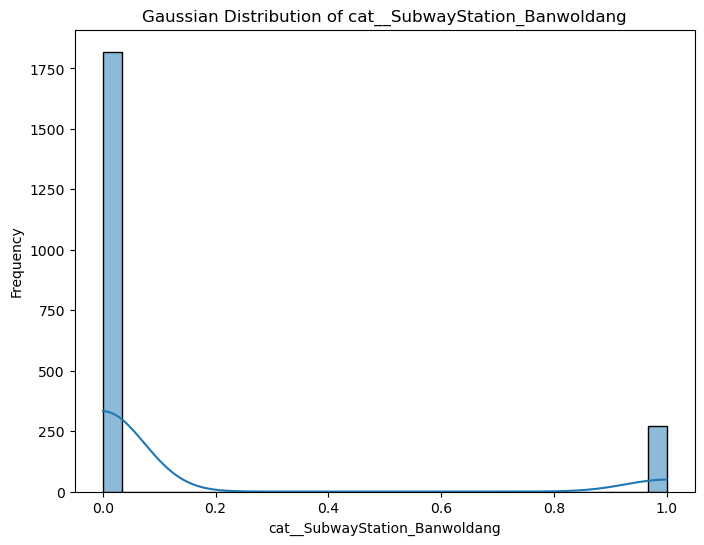

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


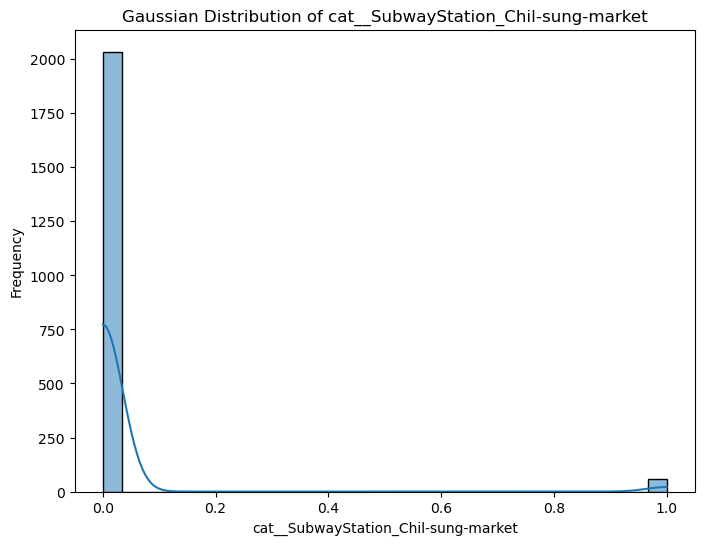

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


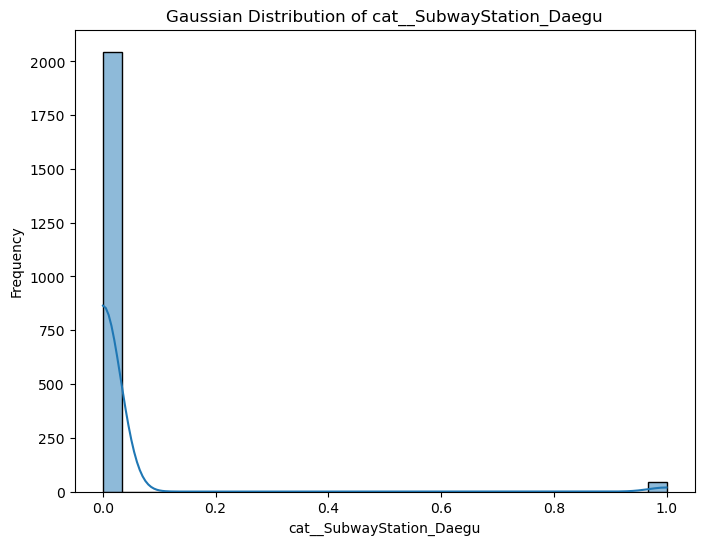

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


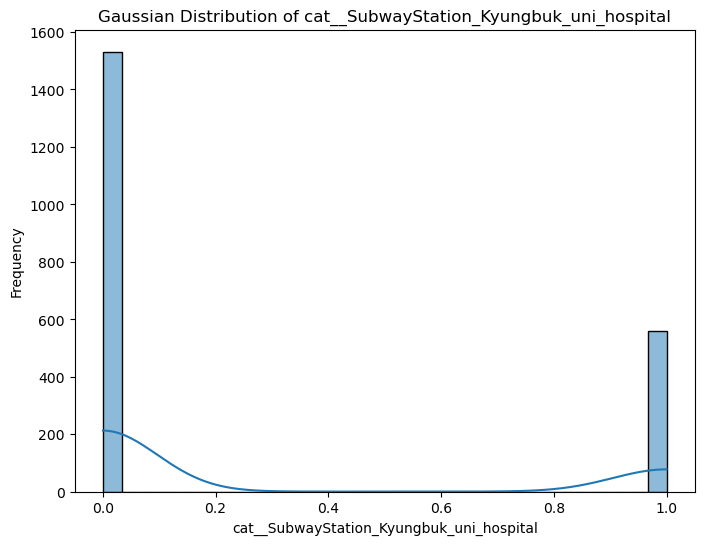

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


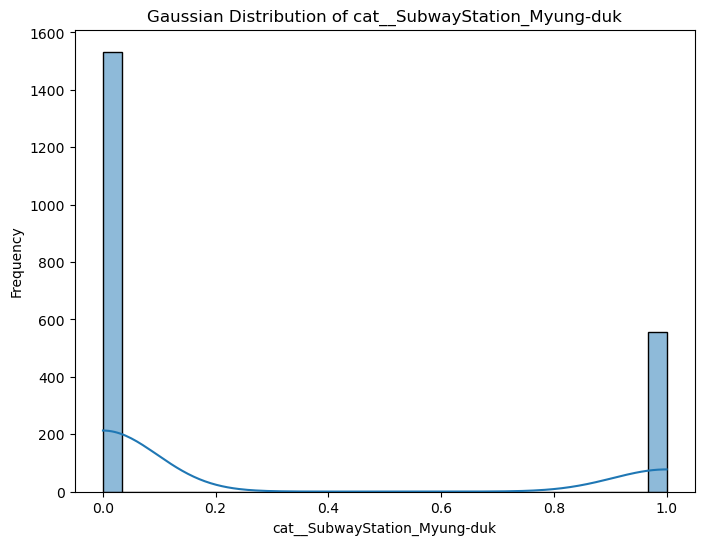

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


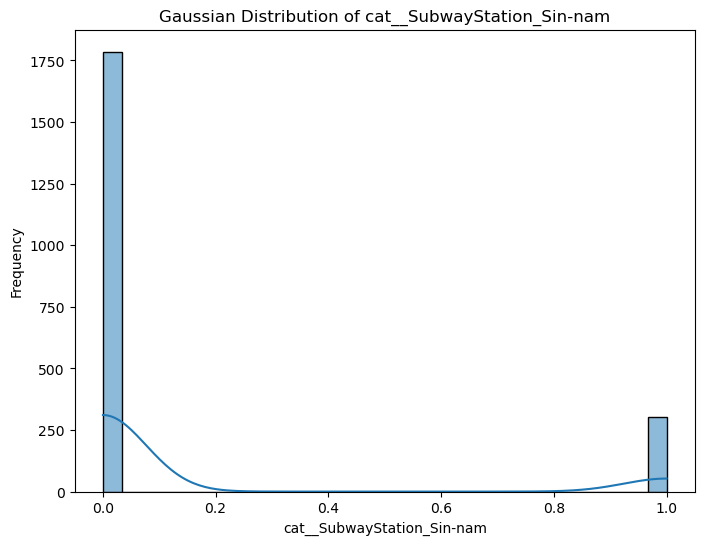

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


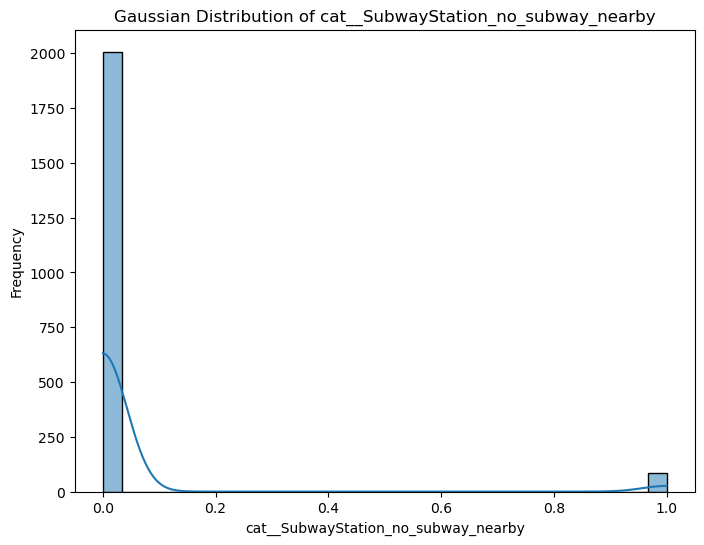

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


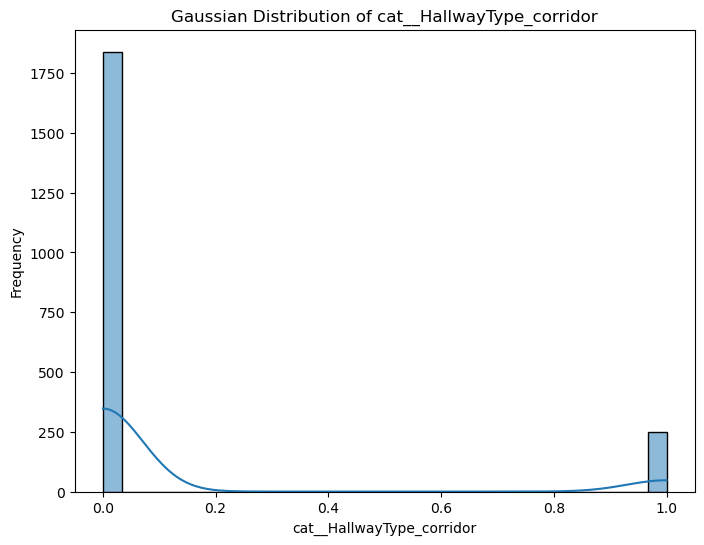

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


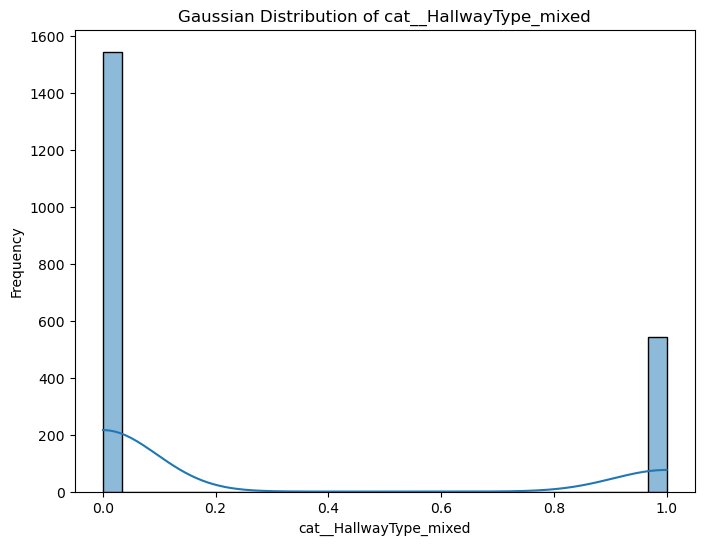

C:\Users\farrel.mahardika\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


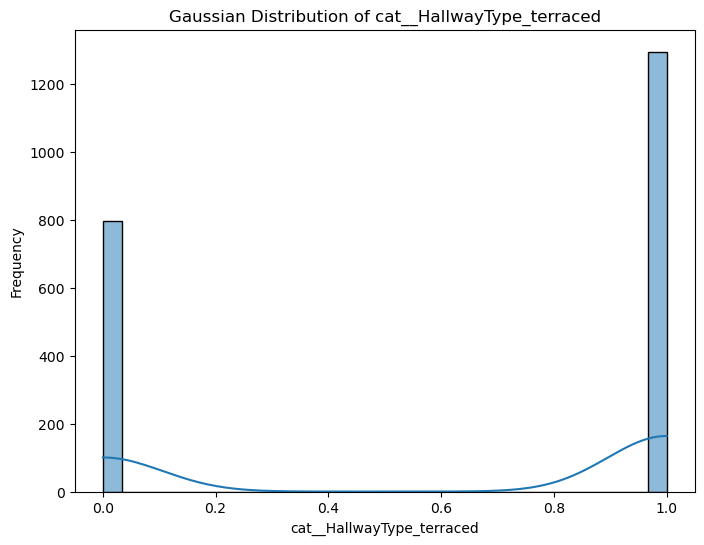

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Gaussian distributions
def plot_gaussian_distributions(df):
    num_cols = df.select_dtypes(include='number').columns
    
    for col in num_cols:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Gaussian Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# Call the function on transformed data
plot_gaussian_distributions(X_train_transformed_df)


### Export to Pickle

In [8]:
import pickle

# Assuming best_model_instance is the trained model from evaluation_results
best_model_instance = evaluation_results[best_model['model_name']]['model']

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model_instance, f)

print("Model saved successfully!")


Model saved successfully!
